# More statistical analysis in Python

This notebook shows how to read, plot and analyse data in Python. If you haven't already done so, you should first work through the `t-test` notebook, as it is a simpler introduction to this one.

In this example, we have three user interfaces that have been evaluated in an experiment. Twenty people participated in this study, completing several tasks with each user interface. We recorded the mean task time for each person with each user interface, and would like to investigate the difference in task time between each of them.

## Reading data

As in the previous example, we need to read our data into a _data frame_:

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns

data = pd.read_csv("user_data.csv")
data.agg({'UI-a': ['mean', 'std'], 'UI-b': ['mean', 'std'], 'UI-c': ['mean', 'std']})

,UI-a,UI-b,UI-c
mean,30043.452707,35517.791226,28570.426076
std,8637.482866,6559.384733,9066.855573


Our data frame has four columns: participant ID, and the time measured for each user interface condition. We used the `agg` function from `pandas` to compute the mean and standard deviation task time for each condition. At a glance, we can see the mean task times were 30s, 35.5s and 28.5s, respectively. But, as you know, we cannot draw a conclusion from the mean values alone.

## Plotting data

The following plot shows the distribution of task times from this experiment:

Text(0, 0.5, 'Density')

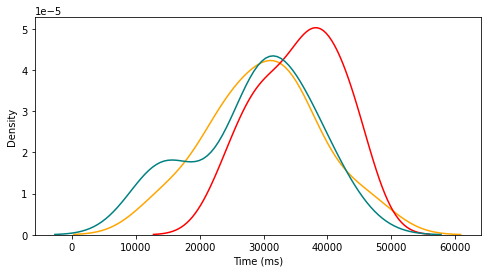

In [51]:
plot, axis = plt.subplots(figsize=(8, 4))
sns.distplot(data['UI-a'], hist=False, color="orange")
sns.distplot(data['UI-b'], hist=False, color="red")
sns.distplot(data['UI-c'], hist=False, color="teal")
axis.set_xlabel("Time (ms)")
axis.set_ylabel("Density")

This plot suggests that the _UI-b_ condition has slightly longer task times than the other two. However, as you know, this is insufficient evidence for us to make an inference from. We need evidence to support a conclusion, meaning some statistical analysis is necessary.

Our example data here is from a within-subject experiment with 20 participants and three conditions. Whilst our last example used a t-test, we cannot use the same method here because we have three groups of related data to compare. The most appropriate statistical test for this investigation is a repeated measures ANOVA (analysis of variance). This compares paired observations from three or more groups - i.e., our three conditions.

## Formatting data

In order to perform an ANOVA, our data needs to be in _long_ format. This means that our data frame needs to have a single row for every participant x condition combination. Currently, our `data` variable is in _wide_ format - with a single row for each participant. It is therefore necessary to reformat our table, before we can analyse our data.

We can use the `melt` function from `pandas` to convert our _wide_ data frame into a _long_ data frame. The following function call identifies the columns(s) we want to group by (in this case, participant), and the column(s) we want to give their own row (in this case, our three experiment conditions). Note the use of the `head` function to peek at the new data format.

In [52]:
data_long = pd.melt(data, id_vars='Participant', value_vars=['UI-a', 'UI-b', 'UI-c'])
data_long.columns = ["Participant", "Condition", "Time"]

print(data_long.head(5))

   Participant Condition         Time
0            1      UI-a  31646.26644
1            2      UI-a  14189.38118
2            3      UI-a  33368.93885
3            4      UI-a  27835.09954
4            5      UI-a  35226.10179


## Statistical analysis: repeated measures ANOVA

Using the `rm_anova` function from `pingouin`, we can perform a repeated measures ANOVA on our experiment data. In the function call, we identify our _dependent variable_ (the newly created _Time_ column with the task times) and our _independent variable_ (the newly created _Condition_ column, which indicates the user interface condition). We also identify the _Participant_ column as the variable by which our measurements are repeated.

In [53]:
aov = pg.rm_anova(dv='Time', within='Condition', subject='Participant', data=data_long)
pg.print_table(aov)


ANOVA SUMMARY

Source       ddof1    ddof2      F    p-unc    np2    eps
---------  -------  -------  -----  -------  -----  -----
Condition        2       38  3.888    0.029  0.170  0.979



An ANOVA test gives us different output from the t-test we saw previously. In this case, the test output gives us an F-statistic, which is somewhat similar to the t-statistic. Here we can see that $F = 3.888$, and the probability of obtaining this result is $p = 0.029$. Since this is below our chosen $\alpha = 0.05$, we reject the null hypothesis for this test and conclude that our independent variable has a significant effect on our dependent variable.

However, this test result cannot tell us what that effect is. In other words, it does not tell us which conditions are significantly different to each other. This requires more analysis...

### Post hoc pairwise comparisons

When a test of more than two conditions tells us there is a significant main effect, we need to perform further comparisons to understand the relationship between each pair of independent variables. These further tests are known as _post hoc tests_, because they take place _post hoc_ (Latin for "after the fact").

In this instance, we need to perform multiple pairwise comparisons between all of our experiment conditions: i.e., three tests, comparing every unique pair. Since we performed an ANOVA, the appropriate post hoc comparison is the t-test. We can use the `pairwise_ttests` function from `pingouin` to perform these comparisons for us:

In [54]:
posthocs = pg.pairwise_ttests(dv='Time', within='Condition', subject='Participant', data=data_long)
pg.print_table(posthocs)


POST HOC TESTS

Contrast    A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
----------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
Condition   UI-a  UI-b  True      True          -2.250  19.000  two-sided    0.037   1.780    -0.700
Condition   UI-a  UI-c  True      True           0.550  19.000  two-sided    0.588   0.266     0.163
Condition   UI-b  UI-c  True      True           2.521  19.000  two-sided    0.021   2.803     0.861



For each row of the output, we can see the results from a pairwise comparison; e.g., the first row compared _UI-a_ with _UI-b_. The `T` column and `p-unc` are our t-statistic and p-value, respectively.

We can see there was a significant difference between _UI-a_ and _UI-b_, and between _UI-b_ and _UI-c_ (p = 0.037 and p = 0.021, respectively). However, we did not find a significant difference between _UI-a_ and _UI_c_ (p = 0.588, which is greater than our $\alpha = 0.05$).

From our results, we can conclude that _UI-a_ and _UI-c_ led to faster task times than _UI-b_. This is supported by our experimental data and the results from the statistical tests.

Note that although we did not find a significant difference between _UI-a_ and _UI-c_, this does **not** mean they are "similar", "comparable", or "the same". We simply don't have the evidence that conclude that they are significantly different from each other.

## Reporting our results

A repeated measures ANOVA found a significant main effect of condition on task time: $F(2, 38) = 3.89, p = 0.03$. Post hoc pairwise comparisons found a significant difference between _UI-a_ and _UI-b_ ($t(19) = -2.25, p = 0.04$) and between _UI-b_ and _UI-c_ ($t(19) = 2.52, p = 0.02$); the difference between _UI-a_ and _UI-c_ was not significant ($t(19) 